In [31]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [32]:
%reload_ext autoreload

In [33]:
import os

# move to project root
while True:
    # get list of directories
    dirs = os.listdir()
    if "README.md" in dirs:
        break
    else:
        os.chdir("..")

# then move to feature extraction
os.chdir("feature_extraction")

print(os.getcwd())

/Users/supriyatno/codes/timescales_filtering/feature_extraction


In [34]:
from utils import load_story_info
from hard_coded_things import featuresets_dict, train_stories, test_stories

import numpy as np

from typing import Dict, List

from tqdm.notebook import trange, tqdm
from typing import Optional
from scipy.signal import periodogram, welch

import matplotlib.pyplot as plt
import seaborn as sns

from signal_processing import compute_psd, upsample_story
from utils import get_dir
from hard_coded_things import frequency_to_period_name_dict
from save_features import save_filtered_features, get_save_file_breakpoints, get_savename_template


In [35]:
from config import config_plotting

In [36]:
config_plotting(context="paper", palette="muted")

In [37]:
fft_size = 1024
sr = 10

n_neurons = 9984

seed = 1

upsampling_method = "linear"
normalized_psd = True

is_chinese=True

aggregation_method = 'mean'

cache = ".cache/spectral_analysis/zh"

In [38]:
if not os.path.exists(cache):
    os.makedirs(cache)

In [9]:
all_stories = train_stories + test_stories
grid_dir, trfile_dir = get_dir(is_chinese=is_chinese)

# Upsampling Stories

In [39]:

story_data_bert_en= {}
for s in all_stories:
    story_data_bert_en[s] = upsample_story(
        s,
        new_sr=sr,
        upsampling_method=upsampling_method,
        story_grid_dir=grid_dir,
        story_trfile_dir=trfile_dir,
        featureset_name="chinese_BERT_all",
        cache=cache
    )

In [40]:
story_data_mbert_en= {}
for s in all_stories:
    story_data_mbert_en[s] = upsample_story(
        s,
        new_sr=sr,
        upsampling_method=upsampling_method,
        story_grid_dir=grid_dir,
        story_trfile_dir=trfile_dir,
        featureset_name="mBERT_all",
        cache=cache
    )

# Spectral Density Analysis

In [41]:
def compute_psd_per_channel(story_data: dict, story_list: List = train_stories):
    n_neurons = story_data_bert_en[train_stories[0]]['story_data'].shape[1]
    psds = np.zeros((n_neurons, fft_size // 2 + 1))
    f = None
    for n in trange(n_neurons):
        # join for all stories
        joint_data = np.concatenate([story_data[s]['story_data'][:, n] for s in story_list])
        # compute periodogram
        f, psds[n] = welch(joint_data, fs=sr, nperseg=fft_size, return_onesided=True)
        # f, psds[n] = periodogram(joint_data, fs=sr, nfft=fft_size)
        
    return f, psds

In [42]:
f, bert_periodograms = compute_psd_per_channel(story_data_bert_en, story_list = train_stories)
f, mbert_periodograms = compute_psd_per_channel(story_data_mbert_en, story_list = train_stories)

  0%|          | 0/9984 [00:00<?, ?it/s]

  0%|          | 0/9984 [00:00<?, ?it/s]

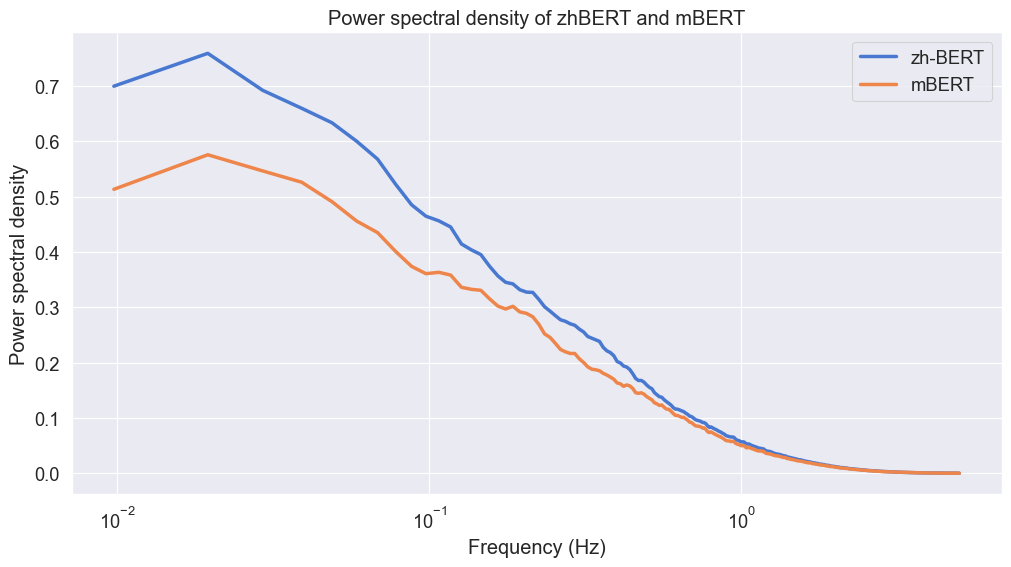

In [60]:
# plot PSDs for BERT and mBERT 
plt.figure(figsize=(12, 6))

plt.plot(f[1:], np.mean(bert_periodograms, axis=0)[1:], label="zh-BERT")
plt.plot(f[1:], np.mean(mbert_periodograms, axis=0)[1:], label="mBERT")

plt.xlabel("Frequency (Hz)")
plt.ylabel("Power spectral density")
plt.title("Power spectral density of zhBERT and mBERT")

# log scale
plt.xscale("log")

plt.legend()
plt.show()
        

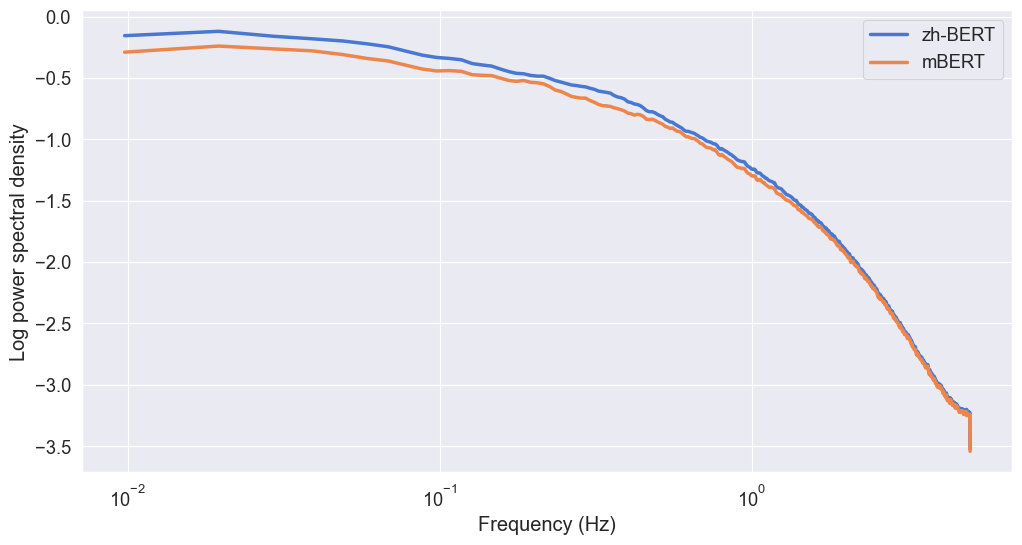

In [58]:
# plot PSDs for BERT and mBERT in dB scale
plt.figure(figsize=(12, 6))

plt.plot(f[1:], np.log10(np.mean(bert_periodograms, axis=0)[1:]), label="zh-BERT")
plt.plot(f[1:], np.log10(np.mean(mbert_periodograms, axis=0)[1:]), label="mBERT")

plt.xlabel("Frequency (Hz)")
plt.ylabel("Log power spectral density")

# log scale
plt.xscale("log")

plt.legend()

plt.show()


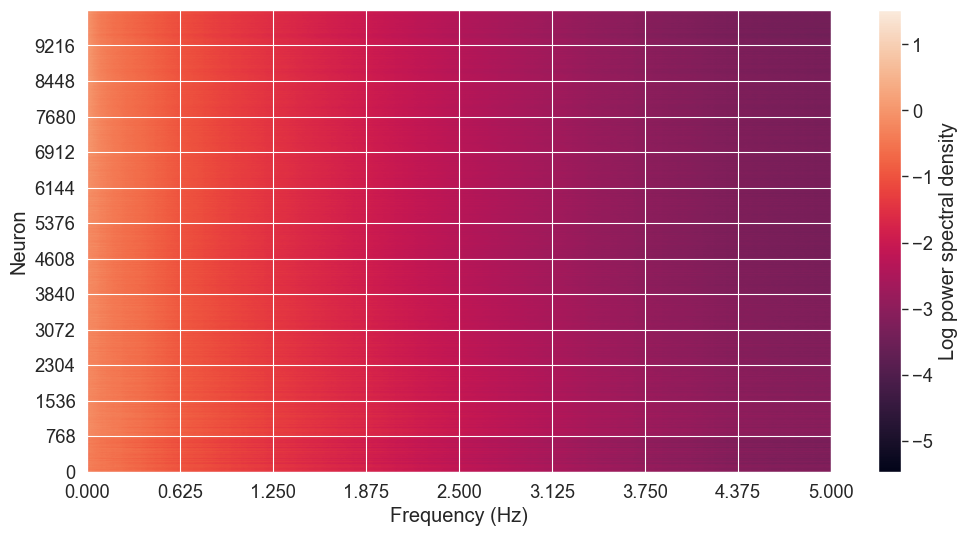

In [54]:
# plot psd imshow for BERT
plt.figure(figsize=(12, 6))

plt.imshow(np.log10(bert_periodograms), aspect='auto', origin='lower', extent=[f[0], f[-1], 0, bert_periodograms.shape[0]])
plt.ylabel("Neuron")
plt.xlabel("Frequency (Hz)")

# set ticks to f
plt.xticks(f[::64])

# set y ticks by range of 768
plt.yticks(np.arange(0, mbert_periodograms.shape[0], 768))

# add colorbar
plt.colorbar(label="Log power spectral density")


plt.show()

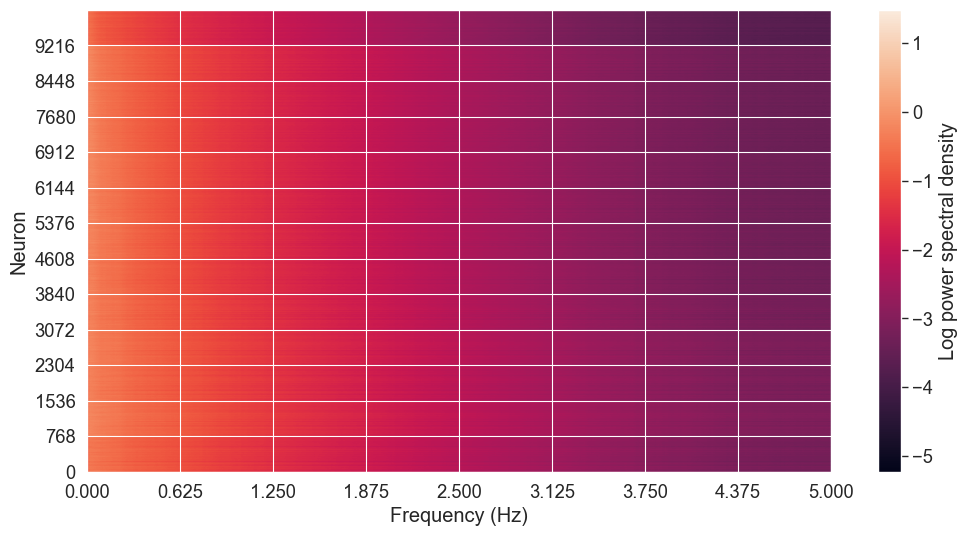

In [55]:
# now for mBERT
plt.figure(figsize=(12, 6))

plt.imshow(np.log10(mbert_periodograms), aspect='auto', origin='lower', extent=[f[0], f[-1], 0, mbert_periodograms.shape[0]])
plt.ylabel("Neuron")
plt.xlabel("Frequency (Hz)")

# set ticks to f
plt.xticks(f[::64])

# set y ticks by range of 768
plt.yticks(np.arange(0, mbert_periodograms.shape[0], 768))

plt.colorbar(label="Log power spectral density")


plt.show()

# Construct timescale feature

In [16]:
import pickle

from save_features import save_filtered_features, get_save_file_breakpoints, get_savename_template

In [18]:
save_file_breakpoints = get_save_file_breakpoints(n_neurons)

lang='zh'

## running filtering

In [ ]:
# save filtered feature
for story in all_stories:
    for breakpoint_start, breakpoint_end in zip(
        [0] + save_file_breakpoints[:-1], save_file_breakpoints
    ):
        save_dir = os.path.join('intermediate_outputs', featureset_name, lang)
        os.makedirs(save_dir, exist_ok=True)
        
        save_filtered_features(
            story,
            featureset_name=featureset_name,
            num_neurons=n_neurons,
            neuron_index_range=range(breakpoint_start, breakpoint_end),
            story_grid_dir=grid_dir,
            story_trfile_dir=trfile_dir,
            save_dir = save_dir,
        )

## grouping data

In [20]:
def save_timescale_feature(feature_set_name='mBERT_all', lang='zh', save_dir="timescale_features", stories: List[str] = all_stories):
    feature_save_dir = os.path.join(save_dir, feature_set_name, lang)
    os.makedirs(feature_save_dir, exist_ok=True)
    
    filtered_data = {}
    for story in stories:
        temps = []
        for breakpoint_start, breakpoint_end in zip(
            [0] + save_file_breakpoints[:-1], save_file_breakpoints
        ):
            save_dir = os.path.join('intermediate_outputs', feature_set_name, lang)

            with open(
                get_savename_template(
                    story_name = story,
                    neuron_index_range=range(breakpoint_start, breakpoint_end),
                    featureset_name = feature_set_name,
                    step_name='filter',
                    save_filepath = save_dir,
                ), 'rb'
            ) as f:
                filtered_stimulus_band = pickle.load(f)
                temps.append(filtered_stimulus_band)
            
        filtered_data[story] = temps.copy()
    # joint all features
    freqs = list(frequency_to_period_name_dict.keys())

    for story in list(filtered_data.keys()):
        story_data = filtered_data[story]
        chunks = len(story_data)
        timescale = {}
        for i, freq in enumerate(freqs):
            timescale[str(freq)] = np.concatenate([story_data[j][freq] for j in range(chunks)], axis=1).T
            
        save_path = os.path.join(feature_save_dir, f'{story}.npz')
        
        np.savez_compressed(save_path, **timescale)


In [21]:
save_timescale_feature(feature_set_name='mBERT_all', lang='zh', stories=all_stories)
save_timescale_feature(feature_set_name='chinese_BERT_all', lang='zh', stories=all_stories)

# Fitting model

In [28]:
import pandas as pd

from himalaya.kernel_ridge import KernelRidgeCV
from himalaya.scoring import r2_score

from sklearn import model_selection

import matplotlib.pyplot as plt
import seaborn as sns

In [23]:
timescale_feature_dir = 'timescale_features'

lang='zh'

story = all_stories[0]

In [24]:
def timescale_regression_analysis(
    target_featureset_name: str,
    input_featureset_name: str,
    lang: str,
    story: str
):
    target_dir = os.path.join(timescale_feature_dir, target_featureset_name, lang)
    input_dir = os.path.join(timescale_feature_dir, input_featureset_name, lang)
    
    target_data = np.load(os.path.join(target_dir, f'{story}.npz'))
    input_data = np.load(os.path.join(input_dir, f'{story}.npz'))
    
    fcs = list(frequency_to_period_name_dict.keys())

    timescale_scores = {}
    for fc in fcs:                
        X = target_data[str(fc)].T
        Y = input_data[str(fc)].T
        
        if np.allclose(X, Y):
            print('target and input are the same')
            break

        # spliting data
        X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, Y, test_size=0.2,random_state=seed)

        model = KernelRidgeCV(
            kernel='linear',
            alphas=np.logspace(-2, 2, 11)
        )

        model.fit(X_train, Y_train)
        
        Y_test_pred = model.predict(X_test)

        # compute r2
        scores = r2_score(Y_test, Y_test_pred)
        
        stat = {
            'mean': np.mean(scores),
            'std': np.std(scores)
        }
        timescale_scores[frequency_to_period_name_dict[fc]] = stat
    
    return timescale_scores
    

In [25]:
timescale_stats = timescale_regression_analysis(
    target_featureset_name = 'mBERT_all',
    input_featureset_name = 'chinese_BERT_all',
    lang = lang,
    story = story
)

In [26]:
timescale_stats_rev = timescale_regression_analysis(
    target_featureset_name = 'chinese_BERT_all' ,
    input_featureset_name = 'mBERT_all',
    lang = lang,
    story = story
)

In [29]:
timescale_stats = pd.DataFrame(timescale_stats)

## plotting

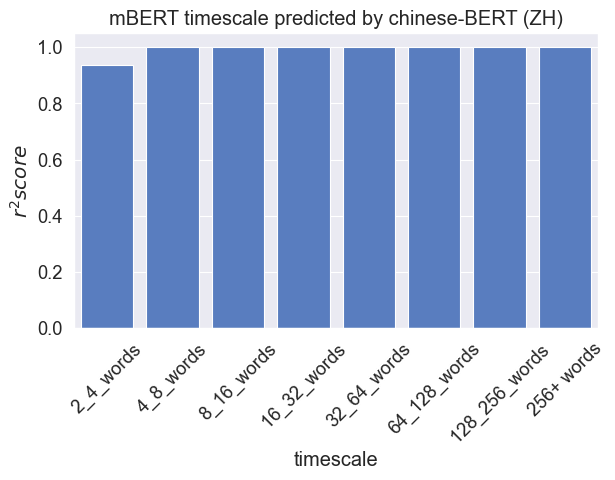

In [30]:
# plot mean barplot
sns.barplot(x=timescale_stats.columns, y=timescale_stats.loc['mean'])

# tilt xlabel
plt.xticks(rotation=45)
plt.xlabel('timescale')
plt.ylabel(r'$r^2 score$')

plt.tight_layout()

plt.title('mBERT timescale predicted by chinese-BERT (ZH)')
plt.show()